In [ ]:
import math
import random
import re
import unicodedata
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import editdistance
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


# Data: Load and Clean French–English Pairs

In [ ]:
!wget -nc https://download.pytorch.org/tutorial/data.zip
!unzip -n data.zip

File ‘data.zip’ already there; not retrieving.

Archive:  data.zip


## Utils

In [ ]:
def unicode_to_ascii(s: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_string(s: str) -> str:
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read file
def read_langs(lang1="eng", lang2="fra", reverse=True):
    lines = open("data/%s-%s.txt" % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    pairs = [[normalize_string(s) for s in l.split('\t')[:2]] for l in lines]
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]  # (fra, eng)
        input_lang_name, output_lang_name = lang2, lang1
    else:
        input_lang_name, output_lang_name = lang1, lang2
    return input_lang_name, output_lang_name, pairs

## Language indexer

In [ ]:
class Lang:
    def __init__(self, name: str):
        self.name = name
        self.word2idx = {"<PAD>":0, "<SOS>":1, "<EOS>":2}
        self.idx2word = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>"}
        self.n_words = 3  # Count PAD, SOS, EOS

    def add_sentence(self, sentence: str):
        for word in sentence.split(" "):
            self.add_word(word)

    def add_word(self, word: str):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.n_words += 1


## Load and filter pairs (you can plug in your custom filters here)

In [ ]:
input_lang_name, output_lang_name, pairs = read_langs()
print(f"Total raw pairs: {len(pairs)}")

MAX_LEN = 15

def filter_pair(p: Tuple[str,str]) -> bool:
    return len(p[0].split(' ')) < MAX_LEN and len(p[1].split(' ')) < MAX_LEN

pairs = [p for p in pairs if filter_pair(p)]
print(f"Filtered pairs: {len(pairs)}")

input_lang = Lang(input_lang_name)
output_lang = Lang(output_lang_name)

for src, tgt in pairs:
    input_lang.add_sentence(src)
    output_lang.add_sentence(tgt)

print("Input vocab size:", input_lang.n_words)
print("Output vocab size:", output_lang.n_words)


Total raw pairs: 135842
Filtered pairs: 130187
Input vocab size: 20392
Output vocab size: 12364


## Shuffle and split into train/val/test

In [ ]:
random.shuffle(pairs)
train_size = int(0.7 * len(pairs))
val_size   = int(0.2 * len(pairs))

train_pairs = pairs[:train_size]
val_pairs   = pairs[train_size:train_size+val_size]
test_pairs  = pairs[train_size+val_size:]

len(train_pairs), len(val_pairs), len(test_pairs)

(91130, 26037, 13020)

# Dataset and Collation (Dataloader)

In [ ]:
def indexes_from_sentence(lang: Lang, sentence: str) -> List[int]:
    return [lang.word2idx["<SOS>"]] + [lang.word2idx[w] for w in sentence.split(" ")] + [lang.word2idx["<EOS>"]]

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang, to_sort=True):
        if to_sort:
            self.pairs = sorted(pairs, key=lambda x: len(x[0].split()))
        else:
            self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src_idx = indexes_from_sentence(self.input_lang, src)
        tgt_idx = indexes_from_sentence(self.output_lang, tgt)
        return torch.tensor(src_idx, dtype=torch.long), torch.tensor(tgt_idx, dtype=torch.long)

In [ ]:
def collate_fn(batch):
    srcs, tgts = zip(*batch)
    srcs = nn.utils.rnn.pad_sequence(srcs, batch_first=True, padding_value=0)
    tgts = nn.utils.rnn.pad_sequence(tgts, batch_first=True, padding_value=0)
    return srcs, tgts

In [ ]:
BATCH_SIZE = 128

train_dataset = TranslationDataset(train_pairs, input_lang, output_lang, to_sort=True)
val_dataset   = TranslationDataset(val_pairs, input_lang, output_lang, to_sort=False)
test_dataset  = TranslationDataset(test_pairs, input_lang, output_lang, to_sort=False)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [ ]:
i=0
LIM = 3
for srcs, tgts in train_loader:
    print(f"\nSource batch shape: {srcs.shape}, Target batch shape: {tgts.shape}")

    first_src_indices = srcs[0].tolist()
    first_src_sentence = ' '.join([input_lang.idx2word[idx] for idx in first_src_indices if idx != 0]) # exclude PAD tokens
    print(f"First source sentence: {first_src_sentence}")

    first_tgt_indices = tgts[0].tolist()
    first_tgt_sentence = ' '.join([output_lang.idx2word[idx] for idx in first_tgt_indices if idx != 0]) ]
    print(f"First target sentence: {first_tgt_sentence}")

    if i==LIM:
      break
    i+=1


Source batch shape: torch.Size([128, 16]), Target batch shape: torch.Size([128, 15])
First source sentence: <SOS> c est elle le soutien de famille . <EOS>
First target sentence: <SOS> she s the breadwinner in this family . <EOS>

Source batch shape: torch.Size([128, 16]), Target batch shape: torch.Size([128, 16])
First source sentence: <SOS> il ne semblait pas y avoir de probleme . <EOS>
First target sentence: <SOS> there didn t seem to be a problem . <EOS>

Source batch shape: torch.Size([128, 16]), Target batch shape: torch.Size([128, 16])
First source sentence: <SOS> tom ne voulait pas s asseoir a cote de moi . <EOS>
First target sentence: <SOS> tom didn t want to sit next to me . <EOS>

Source batch shape: torch.Size([128, 16]), Target batch shape: torch.Size([128, 14])
First source sentence: <SOS> tu connais la rengaine . <EOS>
First target sentence: <SOS> you know the drill . <EOS>


# Word2Vec Embeddings

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import Word2Vec
import numpy as np

EMBED_DIM = 256  # d_model for transformer


In [ ]:
# Build sentence lists
src_sentences = [src.split(" ") for src, _ in train_pairs]
tgt_sentences = [tgt.split(" ") for _, tgt in train_pairs]

In [ ]:
# train Word2Vec separately for source and target languages
src_w2v = Word2Vec(
    sentences=src_sentences,
    vector_size=EMBED_DIM,
    window=5,
    min_count=1,
    workers=4
)

tgt_w2v = Word2Vec(
    sentences=tgt_sentences,
    vector_size=EMBED_DIM,
    window=5,
    min_count=1,
    workers=4
)

In [ ]:
# build embedding matrices aligned with Lang indices
src_embedding_matrix = np.random.normal(
    scale=0.01, size=(input_lang.n_words, EMBED_DIM)
).astype(np.float32)
tgt_embedding_matrix = np.random.normal(
    scale=0.01, size=(output_lang.n_words, EMBED_DIM)
).astype(np.float32)

for word, idx in input_lang.word2idx.items():
    if word in src_w2v.wv:
        src_embedding_matrix[idx] = src_w2v.wv[word]

for word, idx in output_lang.word2idx.items():
    if word in tgt_w2v.wv:
        tgt_embedding_matrix[idx] = tgt_w2v.wv[word]

src_embedding_matrix.shape, tgt_embedding_matrix.shape

((20392, 256), (12364, 256))

In [ ]:
# view a sample of some words and their embeddings for the source language
print("Sample Source Language Embeddings:")
words_to_sample = list(input_lang.word2idx.keys())[3:8] # get a few words after <PAD>, <SOS>, <EOS>
for word in words_to_sample:
    idx = input_lang.word2idx[word]
    embedding = src_embedding_matrix[idx]
    print(f"Word: '{word}' | Embedding shape: {embedding.shape} | First 5 values: {embedding[:5]}")

print("\nSample Target Language Embeddings:")
words_to_sample = list(output_lang.word2idx.keys())[3:8] # get a few words after <PAD>, <SOS>, <EOS>
for word in words_to_sample:
    idx = output_lang.word2idx[word]
    embedding = tgt_embedding_matrix[idx]
    print(f"Word: '{word}' | Embedding shape: {embedding.shape} | First 5 values: {embedding[:5]}")

Sample Source Language Embeddings:
Word: 'va' | Embedding shape: (256,) | First 5 values: [-0.338116   -0.55618215  0.9874926  -0.555723   -0.5838699 ]
Word: '!' | Embedding shape: (256,) | First 5 values: [-0.19898903  0.28175464  0.154378    0.17852913  0.7248731 ]
Word: 'cours' | Embedding shape: (256,) | First 5 values: [-0.08391251 -0.25803807  0.16266757  0.23684023  0.17379683]
Word: 'courez' | Embedding shape: (256,) | First 5 values: [ 0.00526914 -0.02025268  0.01496045  0.0170941   0.00875857]
Word: 'ca' | Embedding shape: (256,) | First 5 values: [ 0.20297028 -0.15871854 -0.2187134   0.01029395 -0.43451127]

Sample Target Language Embeddings:
Word: 'go' | Embedding shape: (256,) | First 5 values: [-0.9485927  -0.30742517  0.5010793  -0.31252673  0.3244286 ]
Word: '.' | Embedding shape: (256,) | First 5 values: [ 0.08564888 -0.03664926 -0.08743935  0.19975534 -0.6428853 ]
Word: 'run' | Embedding shape: (256,) | First 5 values: [-0.12413214 -0.08909257  0.4126194   0.23895754 

# Transformer Components from First Principles

## Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)         # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32) *
            (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len, d_model)
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x


## Scaled dot product attention

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        """
        q, k, v: (batch, heads, seq_len, d_k)
        mask:    (batch, 1, seq_len_q, seq_len_k) with 1 for valid, 0 for masked
        """
        d_k = q.size(-1)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # (b, h, Lq, Lk)

        if mask is not None:
            # mask == 0 -> -inf so softmax ~ 0
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attn = torch.softmax(scores, dim=-1)        # attention weights
        attn = self.dropout(attn)
        output = torch.matmul(attn, v)             # (b, h, Lq, d_k)
        return output, attn


## Multihead attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

        self.attn = ScaledDotProductAttention(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x_q, x_k, x_v, mask=None):
        """
        x_q, x_k, x_v: (batch, seq_len, d_model)
        mask: (batch, 1, seq_len_q, seq_len_k)
        """
        batch_size = x_q.size(0)

        # linear projections
        q = self.w_q(x_q)  # (b,L,d_model)
        k = self.w_k(x_k)
        v = self.w_v(x_v)

        # split into heads: (b, h, L, d_k)
        def split_heads(x):
            return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        q = split_heads(q)
        k = split_heads(k)
        v = split_heads(v)

        if mask is not None and mask.dim() == 3:
            mask = mask.unsqueeze(1)  # (b,1,Lq,Lk)

        context, attn_weights = self.attn(q, k, v, mask=mask)

        # concat heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.fc_out(context)
        out = self.dropout(out)

        # residual + layerNorm
        out = self.layer_norm(out + x_q)
        return out, attn_weights


## Feed forward

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.layer_norm(x + residual)
        return x


## Encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = PositionwiseFeedForward(d_model, d_ff, dropout)

    def forward(self, x, src_mask=None):
        x, _ = self.self_attn(x, x, x, mask=src_mask)
        x = self.ff(x)
        return x


## Decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)   # masked self-attention
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)  # encoder-decoder attention
        self.ff = PositionwiseFeedForward(d_model, d_ff, dropout)

    def forward(self, x, memory, tgt_mask=None, memory_mask=None):
        # masked self-attention over target sequence
        x, _ = self.self_attn(x, x, x, mask=tgt_mask)
        # attention over encoder outputs (memory)
        x, attn_weights = self.cross_attn(x, memory, memory, mask=memory_mask)
        # osition-wise feed-forward
        x = self.ff(x)
        return x, attn_weights


## Transformer

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])

    def forward(self, x, src_mask=None):
        for layer in self.layers:
            x = layer(x, src_mask=src_mask)
        return x

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])

    def forward(self, x, memory, tgt_mask=None, memory_mask=None):
        attn_weights = None
        for layer in self.layers:
            x, attn_weights = layer(x, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return x, attn_weights


In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        src_vocab_size: int,
        tgt_vocab_size: int,
        d_model: int = 256,
        num_heads: int = 8,
        num_layers: int = 3,
        d_ff: int = 512,
        dropout: float = 0.1,
        pad_idx: int = 0,
        src_embedding_matrix=None,
        tgt_embedding_matrix=None
    ):
        super().__init__()
        self.d_model = d_model
        self.pad_idx = pad_idx

        # Embeddings (initialised from Word2Vec, but still trainable)
        if src_embedding_matrix is not None:
            src_weight = torch.tensor(src_embedding_matrix, dtype=torch.float32).to(DEVICE)
            self.src_embedding = nn.Embedding.from_pretrained(
                src_weight, padding_idx=pad_idx, freeze=False
            )
        else:
            self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=pad_idx)

        if tgt_embedding_matrix is not None:
            tgt_weight = torch.tensor(tgt_embedding_matrix, dtype=torch.float32).to(DEVICE)
            self.tgt_embedding = nn.Embedding.from_pretrained(
                tgt_weight, padding_idx=pad_idx, freeze=False
            )
        else:
            self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx=pad_idx)

        self.pos_encoder = PositionalEncoding(d_model)
        self.pos_decoder = PositionalEncoding(d_model)

        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = TransformerDecoder(num_layers, d_model, num_heads, d_ff, dropout)

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def make_src_mask(self, src):
        # src: (batch, src_len)
        mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)  # (b,1,1,src_len)
        return mask

    def make_tgt_mask(self, tgt):
        # tgt: (batch, tgt_len)
        batch_size, tgt_len = tgt.size()
        pad_mask = (tgt != self.pad_idx).unsqueeze(1).unsqueeze(2)  # (b,1,1,L)
        subsequent_mask = torch.tril(
            torch.ones((tgt_len, tgt_len), device=tgt.device)
        ).bool()  # (L, L)
        subsequent_mask = subsequent_mask.unsqueeze(0).unsqueeze(1)  # (1,1,L,L)
        mask = pad_mask & subsequent_mask  # (b,1,L,L)
        return mask

    def forward(self, src, tgt):
        """
        src: (batch, src_len)
        tgt: (batch, tgt_len)   [decoder input, shifted right]
        """
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        memory_mask = self.make_src_mask(src)

        # Embed + scale + positional encoding
        src_emb = self.src_embedding(src) * math.sqrt(self.d_model)
        src_emb = self.pos_encoder(self.dropout(src_emb))

        tgt_emb = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos_decoder(self.dropout(tgt_emb))

        # Encoder
        memory = self.encoder(src_emb, src_mask=src_mask)
        # Decoder
        out, attn_weights = self.decoder(tgt_emb, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)

        logits = self.fc_out(out)  # (batch, tgt_len, tgt_vocab)
        return logits, attn_weights

In [ ]:
# sanity check with dummy data

dummy_src = torch.randint(0, input_lang.n_words, (4, 10)).to(DEVICE)
dummy_tgt = torch.randint(0, output_lang.n_words, (4, 12)).to(DEVICE)

model = Seq2SeqTransformer(
    src_vocab_size=input_lang.n_words,
    tgt_vocab_size=output_lang.n_words,
    d_model=EMBED_DIM,
    num_heads=8,
    num_layers=3,
    d_ff=512,
    dropout=0.1,
    pad_idx=0,
    src_embedding_matrix=src_embedding_matrix,
    tgt_embedding_matrix=tgt_embedding_matrix
).to(DEVICE)

out, attn = model(dummy_src, dummy_tgt)
print("Logits shape:", out.shape)          # (4, 12, tgt_vocab_size)
print("Attention shape:", None if attn is None else attn.shape)


Logits shape: torch.Size([4, 12, 12364])
Attention shape: torch.Size([4, 8, 12, 10])


# Training Loop

In [ ]:

PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2

In [ ]:
def tensor_to_sentence(tensor: torch.Tensor, lang: Lang) -> str:
    """
    Convert a tensor of token indices (including SOS/EOS/PAD)
    back to a plain space-separated sentence string.
    """
    words = []
    for idx in tensor:
        idx = idx.item()
        if idx in (PAD_IDX, SOS_IDX):
            continue
        if idx == EOS_IDX:
            break
        words.append(lang.idx2word.get(idx, "<UNK>"))
    return " ".join(words)

In [ ]:
def greedy_decode(model: nn.Module, src_tensor: torch.Tensor, max_len: int = MAX_LEN+5) -> torch.Tensor:
    """
    Greedy autoregressive decoding for a single source sentence tensor (1D).
    Returns: tensor of predicted target indexes, including SOS and EOS.
    """
    model.eval()
    src = src_tensor.unsqueeze(0).to(DEVICE)  # (1, src_len)
    src_mask = model.make_src_mask(src)

    with torch.no_grad():
        src_emb = model.src_embedding(src) * math.sqrt(model.d_model)
        src_emb = model.pos_encoder(model.dropout(src_emb))
        memory = model.encoder(src_emb, src_mask=src_mask)

        ys = torch.tensor([[SOS_IDX]], dtype=torch.long, device=DEVICE)  # (1,1)

        for _ in range(max_len):
            tgt_mask = model.make_tgt_mask(ys)

            tgt_emb = model.tgt_embedding(ys) * math.sqrt(model.d_model)
            tgt_emb = model.pos_decoder(model.dropout(tgt_emb))

            out, _ = model.decoder(tgt_emb, memory, tgt_mask=tgt_mask, memory_mask=src_mask)
            logits = model.fc_out(out[:, -1, :])  # (1, vocab)
            next_token = logits.argmax(dim=-1).item()

            ys = torch.cat(
                [ys, torch.tensor([[next_token]], dtype=torch.long, device=DEVICE)],
                dim=1
            )
            if next_token == EOS_IDX:
                break

    return ys.squeeze(0)

In [ ]:
def translate_example(model: nn.Module, src_sentence: str) -> str:
    src_idx = torch.tensor(indexes_from_sentence(input_lang, src_sentence),
                           dtype=torch.long)
    decoded = greedy_decode(model, src_idx)
    return tensor_to_sentence(decoded, output_lang)

In [ ]:

def _edit_distance(ref_seq, hyp_seq):
    """
    Classic dynamic programming edit distance.
    ref_seq, hyp_seq: list of tokens (words or chars)
    """
    n = len(ref_seq)
    m = len(hyp_seq)
    dp = [[0]*(m+1) for _ in range(n+1)]

    for i in range(n+1):
        dp[i][0] = i
    for j in range(m+1):
        dp[0][j] = j

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if ref_seq[i-1] == hyp_seq[j-1] else 1
            dp[i][j] = min(
                dp[i-1][j] + 1,      # deletion
                dp[i][j-1] + 1,      # insertion
                dp[i-1][j-1] + cost  # substitution
            )
    return dp[n][m]

def calculate_wer_cer(reference: str, hypothesis: str):
    """
    Compute WER and CER (0–1) between reference and hypothesis strings.
    """
    ref_words = reference.strip().split()
    hyp_words = hypothesis.strip().split()

    if len(ref_words) == 0:
        wer = 0.0
    else:
        wer = _edit_distance(ref_words, hyp_words) / len(ref_words)

    ref_chars = list(reference.replace(" ", ""))
    hyp_chars = list(hypothesis.replace(" ", ""))

    if len(ref_chars) == 0:
        cer = 0.0
    else:
        cer = _edit_distance(ref_chars, hyp_chars) / len(ref_chars)

    return wer, cer

In [ ]:
def _make_src_mask(self, src):
    return (src != self.pad_idx).unsqueeze(1).unsqueeze(2).to(src.device)

def _make_tgt_mask(self, tgt):
    batch_size, tgt_len = tgt.size()
    pad_mask = (tgt != self.pad_idx).unsqueeze(1).unsqueeze(2)  # (b,1,1,L)
    subsequent_mask = torch.tril(
        torch.ones((tgt_len, tgt_len), device=tgt.device)
    ).bool()  # (L,L)
    subsequent_mask = subsequent_mask.unsqueeze(0).unsqueeze(1)  # (1,1,L,L)
    return pad_mask & subsequent_mask


In [ ]:

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
NUM_EPOCHS = 10 

In [ ]:

def train_epoch(model: nn.Module, data_loader: DataLoader,
                optimizer: optim.Optimizer, criterion: nn.Module) -> float:
    model.train()
    total_loss = 0.0

    print("\n--- Starting Training Epoch ---")
    for i, (src, tgt) in enumerate(data_loader):
        # if i % 5 == 0:
        #     print(f"Batch {i}/{len(data_loader)} up for training")

        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input  = tgt[:, :-1]
        tgt_labels = tgt[:, 1:]

        optimizer.zero_grad()
        logits, _ = model(src, tgt_input)       # (batch, L-1, vocab)

        logits = logits.reshape(-1, logits.size(-1))
        tgt_labels = tgt_labels.reshape(-1)

        loss = criterion(logits, tgt_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:

def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                optimizer: optim.Optimizer,
                criterion: nn.Module,
                num_epochs: int,
                model_save_path: str = "best_transformer.pt"):
    """
    Full training loop with:
    - Epoch-wise train & val loss
    - WER/CER on validation
    - Best-model checkpointing by validation WER
    """
    print(f"\nTraining starting on device: {DEVICE}")
    best_val_wer = float("inf")

    train_losses, val_losses, val_wers = [], [], []

    for epoch in range(1, num_epochs + 1):
        print(f"\n=== Epoch {epoch}/{num_epochs} ===")
        start_time = time.time()

        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_wer, val_cer = evaluate_model(model, val_loader, criterion)

        end_time = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_wers.append(val_wer)

        print(f"\nEpoch {epoch} Summary:")
        print(f"  Time:       {end_time - start_time:.2f}s")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss:   {val_loss:.4f}")
        print(f"  Val WER:    {val_wer:.2f}%")
        print(f"  Val CER:    {val_cer:.2f}%")

        if val_wer < best_val_wer:
            print(f"\n🔥 New BEST model! WER improved {best_val_wer:.2f}% → {val_wer:.2f}%")
            best_val_wer = val_wer
            torch.save(model.state_dict(), model_save_path)

    print("\nTraining complete.")
    return train_losses, val_losses, val_wers


In [ ]:

def evaluate_model(model: nn.Module, data_loader: DataLoader,
                   criterion: nn.Module, print_examples: int = 5):
    """
    Evaluate on validation or test set:
    - Average loss
    - Average WER & CER
    - Print a few example translations
    """
    model.eval()
    total_loss, total_wer, total_cer, total_samples = 0, 0, 0, 0
    examples_printed = 0

    print("\n--- Starting Evaluation ---")
    with torch.no_grad():
        for i, (src, tgt) in enumerate(data_loader):
            # if i % 5 == 0:
            #     print(f"Batch {i}/{len(data_loader)} up for eval")

            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)

            tgt_input  = tgt[:, :-1]
            tgt_labels = tgt[:, 1:]

            logits, _ = model(src, tgt_input)
            logits = logits.reshape(-1, logits.size(-1))
            tgt_labels = tgt_labels.reshape(-1)

            loss = criterion(logits, tgt_labels)
            total_loss += loss.item()

            # compute WER/CER per sample
            for b in range(src.size(0)):
                src_sentence = tensor_to_sentence(src[b], input_lang)
                ref_sentence = tensor_to_sentence(tgt[b], output_lang)
                hyp_sentence = translate_example(model, src_sentence)

                if not ref_sentence.strip():
                    continue

                wer, cer = calculate_wer_cer(ref_sentence, hyp_sentence)
                total_wer += wer
                total_cer += cer
                total_samples += 1

                if examples_printed < print_examples:
                    print("-"*50)
                    print(f"Example {examples_printed+1}")
                    print(f"  SRC: {src_sentence}")
                    print(f"  REF: {ref_sentence}")
                    print(f"  HYP: {hyp_sentence}")
                    print(f"  WER: {wer*100:.2f}% | CER: {cer*100:.2f}%")
                    examples_printed += 1

    avg_loss = total_loss / len(data_loader)
    avg_wer  = (total_wer / total_samples) * 100 if total_samples > 0 else 0.0
    avg_cer  = (total_cer / total_samples) * 100 if total_samples > 0 else 0.0

    print("\n" + "="*50)
    print("Evaluation Summary")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average WER:  {avg_wer:.2f}%")
    print(f"Average CER:  {avg_cer:.2f}%")
    print("="*50)

    return avg_loss, avg_wer, avg_cer


In [ ]:
def tensor_to_sentence(tensor, lang: Lang):
    words = []
    for idx in tensor:
        if idx.item() in (PAD_IDX, SOS_IDX):
            continue
        if idx.item() == EOS_IDX:
            break
        words.append(lang.idx2word[idx.item()])
    return " ".join(words)

def translate_example(model, src_sentence: str):
    src_idx = torch.tensor(indexes_from_sentence(input_lang, src_sentence), dtype=torch.long)
    decoded = greedy_decode(model, src_idx)
    translation = tensor_to_sentence(decoded, output_lang)
    return translation

In [ ]:
import time

def train_model(model, train_loader, val_loader, optimizer, criterion,
                num_epochs, model_save_path="best_transformer.pt"):

    print(f"\nTraining starting on device: {DEVICE}")
    best_val_wer = float("inf")

    train_losses, val_losses, val_wers = [], [], []

    for epoch in range(1, num_epochs + 1):
        print(f"\n=== Epoch {epoch}/{num_epochs} ===")
        start = time.time()

        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_wer, val_cer = evaluate_model(model, val_loader, criterion)

        end = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_wers.append(val_wer)

        print(f"\nEpoch Summary {epoch}")
        print(f"Time:        {end-start:.2f}s")
        print(f"Train Loss:  {train_loss:.4f}")
        print(f"Val Loss:    {val_loss:.4f}")
        print(f"Val WER:     {val_wer:.2f}%")
        print(f"Val CER:     {val_cer:.2f}%")

        if val_wer < best_val_wer:
            print(f"\nNew BEST model! WER improved {best_val_wer:.2f}% → {val_wer:.2f}%")
            best_val_wer = val_wer
            torch.save(model.state_dict(), model_save_path)

    print("\nTraining Complete.")
    return train_losses, val_losses, val_wers

In [ ]:

def test_model(model: nn.Module, data_loader: DataLoader,
               criterion: nn.Module, print_examples: int = 10):
    print("\n--- Starting Test Evaluation ---")
    return evaluate_model(model, data_loader, criterion, print_examples)

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, val_wers):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss (Transformer)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # WER
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_wers, 'g-o', label='Validation WER')
    plt.title('Validation WER')
    plt.xlabel('Epoch')
    plt.ylabel('WER (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig("transformer_training_metrics.png")
    plt.show()
    print("\nSaved plot: transformer_training_metrics.png")


In [ ]:

!pip install sacrebleu

In [ ]:
import sacrebleu

def compute_bleu(model: nn.Module, data_loader: DataLoader, max_batches: int = None):
    """
    Compute corpus BLEU over a dataset using greedy decoding.
    """
    model.eval()
    hypotheses = []
    references = []

    print("\n--- Computing BLEU ---")
    with torch.no_grad():
        for b_idx, (src_batch, tgt_batch) in enumerate(data_loader):
            src_batch = src_batch.to(DEVICE)
            tgt_batch = tgt_batch.to(DEVICE)

            for i in range(src_batch.size(0)):
                src_sentence = tensor_to_sentence(src_batch[i], input_lang)
                ref_sentence = tensor_to_sentence(tgt_batch[i], output_lang)
                hyp_sentence = translate_example(model, src_sentence)

                hypotheses.append(hyp_sentence)
                references.append(ref_sentence)

            if max_batches is not None and (b_idx + 1) >= max_batches:
                print(f"Stopped after {max_batches} batches for BLEU.")
                break

    # sacrebleu expects list of refs-lists
    bleu = sacrebleu.corpus_bleu(hypotheses, [references])
    print(f"BLEU = {bleu.score:.2f}")
    return bleu.score

In [ ]:
def get_attention_for_pair(model: nn.Module, src_sentence: str, tgt_sentence: str):
    """
    Run a (src, tgt) pair through the model with teacher forcing,
    and return:
      - attn: (heads, tgt_len, src_len)
      - src_tokens: list[str]
      - tgt_tokens: list[str]
    """
    model.eval()

    src_idx = torch.tensor(indexes_from_sentence(input_lang, src_sentence),
                           dtype=torch.long, device=DEVICE).unsqueeze(0)
    tgt_idx = torch.tensor(indexes_from_sentence(output_lang, tgt_sentence),
                           dtype=torch.long, device=DEVICE).unsqueeze(0)

    tgt_input = tgt_idx[:, :-1]

    with torch.no_grad():
        logits, attn = model(src_idx, tgt_input)  # attn: (batch, heads, L_tgt, L_src)
        attn = attn[0]  # (heads, L_tgt, L_src)

    # Build lists of tokens (excluding PAD/SOS/EOS where appropriate)
    src_tokens = []
    for idx in src_idx[0]:
        w = input_lang.idx2word[idx.item()]
        if w == "<PAD>":
            continue
        src_tokens.append(w)

    tgt_tokens = []
    for idx in tgt_input[0]:
        w = output_lang.idx2word[idx.item()]
        if w in ["<PAD>", "<SOS>"]:
            continue
        tgt_tokens.append(w)

    return attn, src_tokens, tgt_tokens

In [ ]:
def plot_attention_head(attn: torch.Tensor, src_tokens, tgt_tokens, head: int = 0, figsize=(8, 6)):
    """
    Plot heatmap of one attention head.
    attn: (heads, L_tgt, L_src)
    """
    attn_head = attn[head].detach().cpu().numpy()
    src_len = len(src_tokens)
    tgt_len = len(tgt_tokens)
    attn_head = attn_head[:tgt_len, :src_len]

    plt.figure(figsize=figsize)
    plt.imshow(attn_head, aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(src_len), src_tokens, rotation=45, ha='right')
    plt.yticks(range(tgt_len), tgt_tokens)
    plt.xlabel("Source tokens")
    plt.ylabel("Target tokens")
    plt.title(f"Decoder cross-attention head {head}")
    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_attention(model: nn.Module, src_sentence: str, tgt_sentence: str, head: int = 0):
    attn, src_tokens, tgt_tokens = get_attention_for_pair(model, src_sentence, tgt_sentence)
    print("Source tokens:", src_tokens)
    print("Target tokens:", tgt_tokens)
    plot_attention_head(attn, src_tokens, tgt_tokens, head=head)


FR: je suis desole je ne vous ai pas entendus .
EN: i m sorry i didn t hear you .
Source tokens: ['<SOS>', 'je', 'suis', 'desole', 'je', 'ne', 'vous', 'ai', 'pas', 'entendus', '.', '<EOS>']
Target tokens: ['i', 'm', 'sorry', 'i', 'didn', 't', 'hear', 'you', '.']


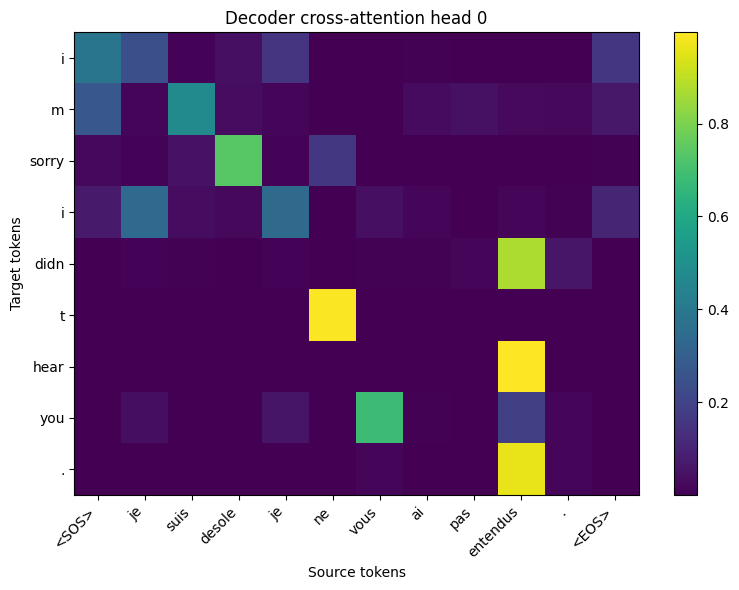

In [ ]:
# Take a random test pair and visualize
src_ex, tgt_ex = random.choice(test_pairs)
print("FR:", src_ex)
print("EN:", tgt_ex)

visualize_attention(model, src_ex, tgt_ex, head=0)


In [ ]:

# train_loader, val_loader, test_loader 

train_losses, val_losses, val_wers = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    model_save_path="best_transformer.pt"
)



Training starting on device: cuda

=== Epoch 1/10 ===

--- Starting Training Epoch ---

--- Starting Evaluation ---
--------------------------------------------------
Example 1
  SRC: je pense que nous devrions toutes aller dehors .
  REF: i think we should all go outside .
  HYP: i think we should all go out .
  WER: 12.50% | CER: 14.81%
--------------------------------------------------
Example 2
  SRC: je ne voulais pas faire ceci au depart .
  REF: i didn t want to do this in the first place .
  HYP: i didn t want to do this to work .
  WER: 33.33% | CER: 38.24%
--------------------------------------------------
Example 3
  SRC: je n en ai qu un pour l instant .
  REF: i only have one so far .
  HYP: i have only one to be right now .
  WER: 85.71% | CER: 94.44%
--------------------------------------------------
Example 4
  SRC: nous sommes endurants .
  REF: we re resilient .
  HYP: we re going to be .
  WER: 75.00% | CER: 64.29%
--------------------------------------------------


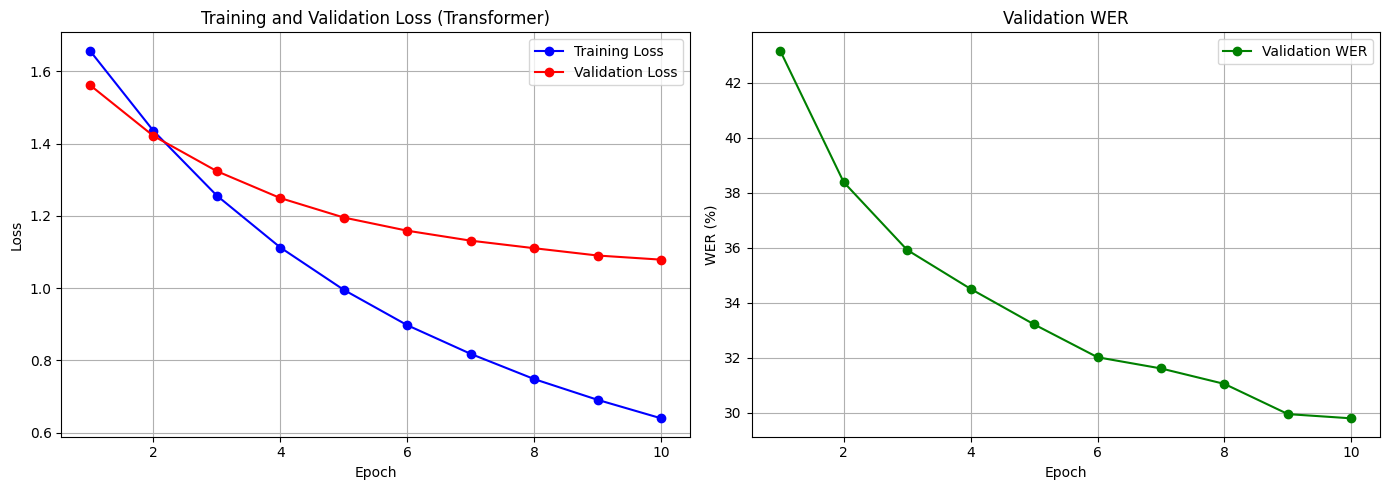


Saved plot: transformer_training_metrics.png


In [ ]:
plot_metrics(train_losses, val_losses, val_wers)

In [ ]:
test_loss, test_wer, test_cer = test_model(
    model,
    test_loader,
    criterion,
    print_examples=10
)

bleu_score = compute_bleu(model, test_loader)
print(f"\nFinal Test BLEU: {bleu_score:.2f}")


--- Starting Test Evaluation ---

--- Starting Evaluation ---
--------------------------------------------------
Example 1
  SRC: je suis devenu occupee .
  REF: i got busy .
  HYP: i became busy .
  WER: 25.00% | CER: 66.67%
--------------------------------------------------
Example 2
  SRC: il y a un risque .
  REF: there s a risk .
  HYP: there s a risk .
  WER: 0.00% | CER: 0.00%
--------------------------------------------------
Example 3
  SRC: le professeur a accueilli les nouveaux eleves .
  REF: the teacher welcomed the new students .
  HYP: the teacher greeted the new students .
  WER: 14.29% | CER: 18.18%
--------------------------------------------------
Example 4
  SRC: eut il entendu les nouvelles il aurait pu etre choque .
  REF: had he heard the news he might have been shocked .
  HYP: he heard the news he could have been shocked .
  WER: 18.18% | CER: 20.00%
--------------------------------------------------
Example 5
  SRC: il n y a personne d autre .
  REF: there is

BLEU = 51.77

Final Test BLEU: 51.77
